<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

## Deliverable 📬

To complete this project, your team should: 

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

___

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import json

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [4]:
import en_core_web_md
nlp = en_core_web_md.load()

## EDA

In [5]:
df = pd.read_csv("../src/spam.csv", encoding="latin-1")

In [6]:
display(df.head())
display(df.describe(include="all"))

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [7]:
# missing values
df.isna().sum() / df.shape[0]

v1            0.000000
v2            0.000000
Unnamed: 2    0.991027
Unnamed: 3    0.997846
Unnamed: 4    0.998923
dtype: float64

In [8]:
# clean and rename columns
df["type"] = df["v1"]
df["text"] = df[df.columns[1:]].apply(lambda x: ",".join(x.dropna().astype(str)), axis=1)
df = df[["type", "text"]]

display(df.head())

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,"Ok lar... Joking wif u oni...,ham"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
px.histogram(df["type"])

## PRE PROCESSING

In [10]:
# encoding target
df["target"] = df["type"].map({"ham": 0,"spam": 1})

In [11]:
# cleaning text with nlp
df["text_clean"] = df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

df.head()

,type,text,target,text_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...
1,ham,"Ok lar... Joking wif u oni...,ham",0,ok lar joke wif u oniham
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c sayham
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live thoughham


In [12]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab")
tokenizer.fit_on_texts(df["text_clean"])
df["text_encoded"] = tokenizer.texts_to_sequences(df["text_clean"])
df.head()

,type,text,target,text_clean,text_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...,"[1, 262, 451, 535, 1, 29, 46, 205, 1, 75, 1, 9..."
1,ham,"Ok lar... Joking wif u oni...,ham",0,ok lar joke wif u oniham,"[16, 263, 620, 272, 2, 1]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 281, 3, 536, 730, 26, 1, 886, 422, 1, 1, ..."
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c sayham,"[2, 123, 173, 1, 2, 78, 1]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live thoughham,"[731, 20, 732, 133, 887]"


In [13]:
# backup pre preprocessing
df.to_csv("preprocessing.csv", index=False)

In [14]:
text_pad = tf.keras.preprocessing.sequence.pad_sequences(df["text_encoded"], padding="post")
text_pad

array([[  1, 262, 451, ...,   0,   0,   0],
       [ 16, 263, 620, ...,   0,   0,   0],
       [ 12, 281,   3, ...,   0,   0,   0],
       ...,
       [  1, 986,   1, ...,   0,   0,   0],
       [112,   1,   1, ...,   0,   0,   0],
       [  1, 359,   1, ...,   0,   0,   0]])

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(text_pad, df["target"],
                                                  test_size=0.3,
                                                  random_state=0)

In [16]:
train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [17]:
for text, typ in train_batch.take(1):  # checking batch content
  print(text, typ)

tf.Tensor(
[[ 24  48   9 ...   0   0   0]
 [ 58  44  65 ...   0   0   0]
 [  1  97  95 ...   0   0   0]
 ...
 [120 122  81 ...   0   0   0]
 [104   1 228 ...   0   0   0]
 [160 483 669 ...   0   0   0]], shape=(64, 74), dtype=int32) tf.Tensor(
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0], shape=(64,), dtype=int64)


## MODELING

### Baseline with LogisticRegression

In [18]:
lr = LogisticRegression(max_iter=1500)
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_val)

print(classification_report(Y_val, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1434
           1       0.64      0.29      0.40       238

    accuracy                           0.88      1672
   macro avg       0.77      0.63      0.66      1672
weighted avg       0.86      0.88      0.85      1672



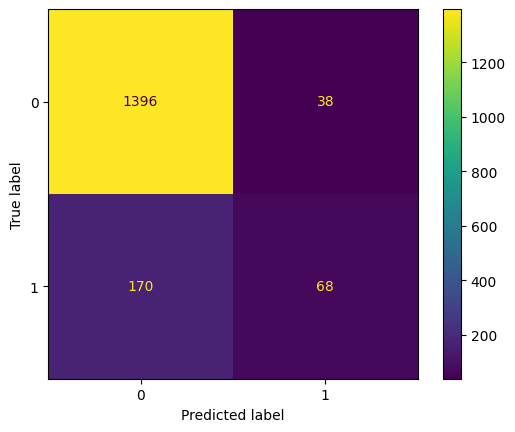

In [19]:
result_lr = pd.DataFrame(Y_val)
result_lr["prediction"] = (Y_pred > 0.5).astype(int)

ConfusionMatrixDisplay(confusion_matrix(result_lr["target"], result_lr["prediction"])).plot()
plt.show()

Not very useful but at least we have something

### Let's make our own deep learning model

In [20]:
vocab_size = tokenizer.num_words

model_simple = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 64, input_shape=[text.shape[1]], name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_simple.summary()

c:\Users\giand\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 74, 64)         │        64,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,337 (274.75 KB)

 Trainable params: 70,337 (274.75 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.MeanSquaredError()
metric = tf.keras.metrics.MeanAbsoluteError()

model_simple.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metric])

In [22]:
history = model_simple.fit(train_batch,
                           epochs=20,
                           validation_data=val_batch)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1365 - mean_absolute_error: 0.2768 - val_loss: 0.1157 - val_mean_absolute_error: 0.2265
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1080 - mean_absolute_error: 0.2324 - val_loss: 0.1141 - val_mean_absolute_error: 0.2143
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1057 - mean_absolute_error: 0.2180 - val_loss: 0.1070 - val_mean_absolute_error: 0.2216
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0937 - mean_absolute_error: 0.2193 - val_loss: 0.0880 - val_mean_absolute_error: 0.2055
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0743 - mean_absolute_error: 0.1886 - val_loss: 0.0745 - val_mean_absolute_error: 0.1906
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0597 - mean_absolute_error: 0.1475 - val_loss: 0.0625 - val_mean_absolute_error: 0.1519
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0470 - mean_absolute_error: 0.1239 - val_loss: 0.048

In [23]:
model_simple.save("model_simple.h5")
json.dump(model_simple.history.history, open("model_simple_history.json", "w"))

In [24]:
history = json.load(open("model_simple_history.json", "r"))

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history["loss"],
                         mode="lines",
                         name="loss"))
fig.add_trace(go.Scatter(y=history["val_loss"],
                         mode="lines",
                         name="val_loss"))
fig.show()

### Testing

In [26]:
# Load the saved model
model = tf.keras.models.load_model("model_simple.h5")

predictions = model.predict(val_batch)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [27]:
df_predict = pd.DataFrame(Y_val)

df_predict["prediction"] = (predictions > 0.5).astype(int)
df_predict

,target,prediction
4456,0,0
690,0,0
944,0,0
3768,0,0
1189,0,0
...,...,...
4833,0,0
3006,0,1
509,0,1
1761,0,0


In [28]:
mask = df_predict["target"] != df_predict["prediction"]
percentage_of_errors = df_predict[mask].shape[0] / df_predict.shape[0] * 100

print(f"There are {round(percentage_of_errors, 2)} % errors in this prediction.")

There are 23.5 % errors in this prediction.


In [29]:
print(classification_report(df_predict["target"], df_predict["prediction"]))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1434
           1       0.09      0.08      0.08       238

    accuracy                           0.76      1672
   macro avg       0.47      0.48      0.47      1672
weighted avg       0.74      0.76      0.75      1672



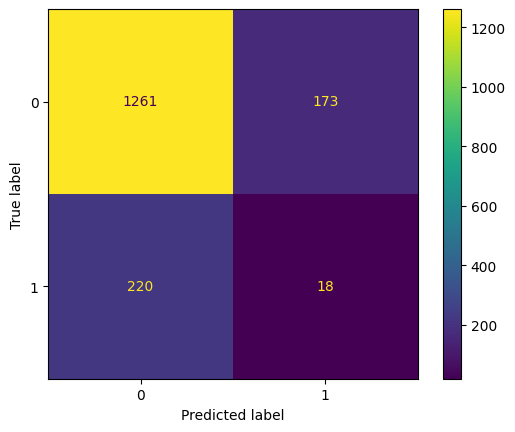

In [30]:
ConfusionMatrixDisplay(confusion_matrix(df_predict["target"], df_predict["prediction"])).plot()
plt.show()

### Transfer Learning with BERT

In [34]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


# Tokenize the input text for BERT
inputs = tokenizer(df["text_clean"].tolist(), return_tensors='tf', max_length=512, truncation=True, padding=True)

# Make predictions
outputs = model(inputs['input_ids'])
predictions = tf.argmax(outputs.logits, axis=-1)

# Map predictions to labels
sample_data = pd.Dataframe()
sample_data['prediction'] = predictions.numpy()
sample_data['prediction'] = sample_data['prediction'].map({0: 'ham', 1: 'spam'})

# Display predictions
print(sample_data[['v2', 'prediction']])


c:\Users\giand\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

c:\Users\giand\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\giand\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
